In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb
import optuna

from sklearn.metrics import mean_squared_error, make_scorer, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, plot_confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics


In [2]:
# pickle ファイルから読み込み
train_pkl = pd.read_pickle('./train.pk2')

In [3]:
train_pkl.shape

(850, 9)

## 訓練データとテストデータに分割

In [4]:
# 訓練とテストデータに分割
train, test = train_test_split(train_pkl, test_size=0.2, random_state=42)

In [5]:
# ターゲットと特徴量の分割
train_X = train.iloc[:, :-1]
train_y = train.disease

In [7]:
# ターゲットと特徴量の分割
test_X = test.iloc[:, :-1]
test_y = test.disease

In [8]:
# LightGBMのモデルへデータセットの初期化セット
train_data = lgb.Dataset(train_X, label=train_y)
test_data =  lgb.Dataset(test_X, label=test_y, reference=train_data)

## LightGBM

In [9]:
# パラメータ
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'verbose': 2
}

In [10]:
# 訓練
gbm = lgb.train(
    params,
    train_data,
    valid_sets=test_data,
    num_boost_round=1000,
    verbose_eval=50,
    early_stopping_rounds=100
)


Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.260654
[100]	valid_0's binary_logloss: 0.2878
[150]	valid_0's binary_logloss: 0.33932
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.255189


In [16]:
# scikit-learn経由で
gbm2 = lgb.LGBMClassifier(objective='binary', n_estimators=1000, seed=42)

In [17]:
gbm2.fit(train_X, train_y, eval_set=[(test_X, test_y)], verbose=50)

[50]	valid_0's binary_logloss: 0.260654
[100]	valid_0's binary_logloss: 0.2878
[150]	valid_0's binary_logloss: 0.33932
[200]	valid_0's binary_logloss: 0.405852
[250]	valid_0's binary_logloss: 0.467527
[300]	valid_0's binary_logloss: 0.53711
[350]	valid_0's binary_logloss: 0.592712
[400]	valid_0's binary_logloss: 0.620502
[450]	valid_0's binary_logloss: 0.637877
[500]	valid_0's binary_logloss: 0.654936
[550]	valid_0's binary_logloss: 0.66333
[600]	valid_0's binary_logloss: 0.667125
[650]	valid_0's binary_logloss: 0.669502
[700]	valid_0's binary_logloss: 0.674407
[750]	valid_0's binary_logloss: 0.679518
[800]	valid_0's binary_logloss: 0.681716
[850]	valid_0's binary_logloss: 0.685558
[900]	valid_0's binary_logloss: 0.687682
[950]	valid_0's binary_logloss: 0.689686
[1000]	valid_0's binary_logloss: 0.692542


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [23]:
preds = gbm2.predict(test_X, num_iteration=gbm.best_iteration)

In [28]:
preds = gbm2.predict_proba(test_X)

In [34]:
y_pred = np.where(preds < 0.5, 0, 1)

In [35]:
pred_y = np.argmax(y_pred, axis=1)

In [37]:
confusion_matrix(test_y, pred_y)

array([[89,  4],
       [19, 58]], dtype=int64)

In [38]:
accuracy_score(test_y, pred_y)

0.8647058823529412

In [40]:
roc_auc_score(test_y, pred_y)

0.8551180002792906

In [41]:
fpr, tpr, thr = roc_curve(test_y, pred_y)

In [44]:
auc = metrics.auc(fpr, tpr)

In [45]:
auc

0.8551180002792906

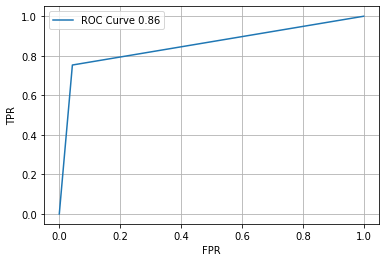

In [46]:
plt.plot(fpr, tpr, label="ROC Curve %.2f"%auc)
plt.legend()
plt.xlabel('FPR')
plt.ylabel("TPR")
plt.grid()
plt.show()

## 検証データで実行

In [47]:
# 検証データ読み込み
valid = pd.read_pickle('./test.pk2')

In [225]:
# ID の保存
# valid_pass = valid.id.values

In [49]:
# valid_X = valid.iloc[:, 1:]
valid_X = valid.copy()

In [50]:
valid_X.shape, train_X.shape

((350, 8), (680, 8))

In [52]:
pred_valid_y = gbm2.predict(valid_X)

In [53]:
pred_valid_y.shape

(350,)

In [54]:
preds = gbm2.predict_proba(valid_X)

In [55]:
y_pred = np.where(preds < 0.5, 0, 1)

In [56]:
pred_y = np.argmax(y_pred, axis=1)

In [230]:
# type(valid_pass), type(pred_valid_y)

In [59]:
result_df = pd.DataFrame(pred_y)

In [60]:
result_df.to_csv("./LGBM_1.csv", header=False)

In [61]:
result_df

,0
0,0
1,0
2,0
3,0
4,0
...,...
345,1
346,0
347,0
348,0
